# Deep Learning Crash Course: From logistic regression to Deep Neural Networks

This notebook covers two examples of classification task as seen in the slides.

- First, the development of a simple logistic regression to classify between dogs and cats is overviewed.

- Second, an improved example based on Deep Neural Networks.

The goal is to see how logistic regression is the base for Deep Neural Networks, and how its combination in more complex architectures improves the accuracy of the model.

The dataset used comes from: https://www.kaggle.com/c/dogs-vs-cats

Below, we see the imports that we need for the following section:

In [1]:
import tensorflow as tf
import tensorflow.keras as keras,os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
import cv2
from sklearn.utils import shuffle

The code below servers for loading the images from files and generating a preprocessed representation of it.

In [2]:
train_images = ["data/train2/"+i for i in os.listdir("data/train2/")]
ROWS = 64
COLS = 64
CHANNELS = 3

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return cv2.resize(img, (ROWS, COLS),interpolation=cv2.INTER_CUBIC)

def prep_data(images):
    m = len(images)
    n_x = ROWS*COLS*CHANNELS
    
    X = np.ndarray((m, ROWS, COLS, CHANNELS), dtype=np.float32)
    y = np.zeros((m))
    print("X.shape is {}".format(X.shape))
    
    for i,image_file in enumerate(images) :
        image = read_image(image_file) / 255
        X[i] = image.reshape((ROWS, COLS, CHANNELS))
        if 'dog' in image_file.lower() :
            y[i] = 1
        elif 'cat' in image_file.lower() :
            y[i] = 0
        else : # for test data
            y[0,i] = image_file.split('/')[-1].split('.')[0]
        if i%5000 == 0 :
            print("Proceed {} of {}".format(i, m))
    
    return X,y


The code below serves for loading and saving the dataset to files once it has been generated. We prefer to do it that way, in order not to preprocess the dataset each time we load it.

In [3]:
def save_dataset(x, y):
    x = np.array(x)
    with open('dataset.npy', 'wb') as f:
        np.save(f, x)
        
    y = np.array(y)
    with open('labels.npy', 'wb') as f:
        np.save(f, y)


def load_dataset():
    with open('dataset.npy', 'rb') as f:
        x = np.load(f)
    with open('labels.npy', 'rb') as f:
        y = np.load(f)
    return x, y


If it is executed for the first time, the cell below generates the dataset in appropriate format.

In [4]:
#x, y = prep_data(train_images)
#save_dataset(x, y)

The cell below loads the dataset from disk and shuffles it for processing.

In [5]:
x, y = load_dataset()
x, y = shuffle(x, y, random_state=0)

The code below plots 4 images out of the dataset

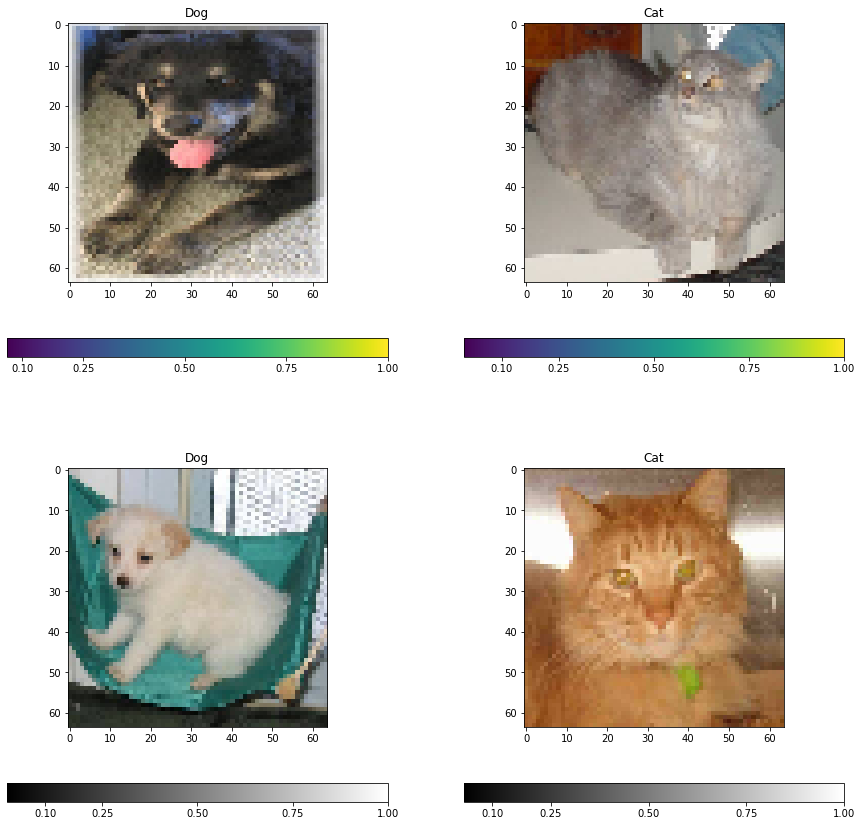

In [6]:

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(2, 2, 1)
imgplot = plt.imshow(x[0])
ax.set_title('Cat' if y[0] == 0.0 else 'Dog')
plt.colorbar(ticks=[0.1, 0.25, 0.5, 0.75, 1.0], orientation='horizontal')
ax = fig.add_subplot(2, 2, 2)
imgplot = plt.imshow(x[1])
ax.set_title('Cat' if y[1] == 0.0 else 'Dog')
plt.colorbar(ticks=[0.1, 0.25, 0.5, 0.75, 1.0], orientation='horizontal')
ax = fig.add_subplot(2, 2, 3)
imgplot = plt.imshow(x[2], cmap='gray')
ax.set_title('Cat' if y[2] == 0.0 else 'Dog')
plt.colorbar(ticks=[0.1, 0.25, 0.5, 0.75, 1.0], orientation='horizontal')
ax = fig.add_subplot(2, 2, 4)
imgplot = plt.imshow(x[4], cmap='gray')
ax.set_title('Cat' if y[4] == 0.0 else 'Dog')
plt.colorbar(ticks=[0.1, 0.25, 0.5, 0.75, 1.0], orientation='horizontal')

First, we try a logistic regression model. It is made of:
- `Flatten` layer: To linearize the 3 dimensional matrices representing the pictures.
- `Dense` layer (with one unit): Equivalent to the logistic regression. Additionally, the dendse layer contains a sigmoid activation function

In [7]:
def get_model():
    model = Sequential()
    model.add(Flatten(input_shape=(ROWS,COLS,CHANNELS))) 
    # ^ Linearizes the array
    model.add(Dense(units=1,activation="sigmoid")) 
    # ^ 1 neuron Neural Network = Logistic Regression
    return model

model = get_model()

Here we compile the model to use the binary_cross_entropy. 

The formula is given by: $L(y, y') = y' \cdot log(y) + (1 - y') \cdot log(x)$

The optimizer regulates how the update of the hyperparameters $\theta_i$ affects them per iteration of gradient descent.

In [8]:

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 1)                 12289     
                                                                 
Total params: 12,289
Trainable params: 12,289
Non-trainable params: 0
_________________________________________________________________


When doing Machine Learning, we usually divide the input dataset in training and test. In general, we want the test dataset to have a sufficient population to check the accuracy. Usually, we can use 60\% - 40\% in Machine Learning. When the training dataset is sufficiently large, we can reduce it. 

In this case we use 90\% - 10\%, because the training dataset has 25000 samples and 10\% encompases 2500 samples (sufficient to test).

In [9]:
split = int(0.9 * len(x))
x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

The fit function receives the training and test sets.

The epochs define the number of iterations that we make the whole dataset.

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
hist = model.fit(x_train, y_train, 
          epochs=50, # If we put more epochs, we have more accuracy
          validation_data=(x_test, y_test), 
          verbose=1)

Epoch 1/50
704/704 [==============================] - 2s 3ms/step - loss: 0.7492 - accuracy: 0.5554 - val_loss: 0.6758 - val_accuracy: 0.5928
Epoch 2/50
704/704 [==============================] - 2s 2ms/step - loss: 0.7415 - accuracy: 0.5694 - val_loss: 0.6995 - val_accuracy: 0.5820
Epoch 3/50
704/704 [==============================] - 1s 2ms/step - loss: 0.7076 - accuracy: 0.5884 - val_loss: 0.8998 - val_accuracy: 0.5256
Epoch 4/50
704/704 [==============================] - 2s 2ms/step - loss: 0.7151 - accuracy: 0.5991 - val_loss: 0.9909 - val_accuracy: 0.5264
Epoch 5/50
704/704 [==============================] - 2s 2ms/step - loss: 0.6984 - accuracy: 0.6036 - val_loss: 0.7677 - val_accuracy: 0.5516
Epoch 6/50
704/704 [==============================] - 2s 2ms/step - loss: 0.7028 - accuracy: 0.6086 - val_loss: 0.6797 - val_accuracy: 0.5904
Epoch 7/50
704/704 [==============================] - 2s 2ms/step - loss: 0.6800 - accuracy: 0.6210 - val_loss: 0.7379 - val_accuracy: 0.5696
Epoch 

This second model is a variation of the first one. The model is composed in this case of three layers.

It also includes the `Flatten` layer that linearices the three dimensional matrix.

Also, it introduces a `Dense` Layer with 100 units / neurons. As we covered, this could also be considered 100 logistic regressions.

These 100 units give their output to the output `Dense` Layer with 1 unit/neuron.

In [11]:
def get_model():
    model = Sequential()
    model.add(Flatten(input_shape=(ROWS,COLS,CHANNELS))) 
    # ^ Linearizes the array
    model.add(Dense(units=100, activation="leaky_relu"))
    # ^ 100 neuron layer
    model.add(Dense(units=1,activation="sigmoid")) 
    # ^ 1 neuron Neural Network = Logistic Regression
    return model

model = get_model()

The parameters for the training are the same as for the previous model.

In [12]:

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 12288)             0         
                                                                 
 dense_1 (Dense)             (None, 100)               1228900   
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,229,001
Trainable params: 1,229,001
Non-trainable params: 0
_________________________________________________________________


On the output, we can observe how this model obtains better results in accuracy in less time. The use of many units/neurons/logistic regressions enables obtaining better output results.

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
hist = model.fit(x_train, y_train, 
          epochs=50,
     
          validation_data=(x_test, y_test), 
          verbose=1)

Epoch 1/50
704/704 [==============================] - 3s 3ms/step - loss: 0.8452 - accuracy: 0.5485 - val_loss: 1.0096 - val_accuracy: 0.5148
Epoch 2/50
704/704 [==============================] - 2s 3ms/step - loss: 0.7416 - accuracy: 0.5712 - val_loss: 0.6593 - val_accuracy: 0.5960
Epoch 3/50
704/704 [==============================] - 2s 3ms/step - loss: 0.6925 - accuracy: 0.6065 - val_loss: 0.7813 - val_accuracy: 0.5460
Epoch 4/50
704/704 [==============================] - 2s 3ms/step - loss: 0.6604 - accuracy: 0.6208 - val_loss: 0.7140 - val_accuracy: 0.5660
Epoch 5/50
704/704 [==============================] - 2s 3ms/step - loss: 0.6546 - accuracy: 0.6216 - val_loss: 0.6714 - val_accuracy: 0.5956
Epoch 6/50
704/704 [==============================] - 2s 3ms/step - loss: 0.6399 - accuracy: 0.6348 - val_loss: 0.7593 - val_accuracy: 0.5536
Epoch 7/50
704/704 [==============================] - 2s 3ms/step - loss: 0.6404 - accuracy: 0.6341 - val_loss: 0.6426 - val_accuracy: 0.6296
Epoch 